# Analysis Pipeline

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
from tgf import Task, TaskGroup, Flag, AbstractTask, AbstractFlag, Pipeline, BaseFlag
from plotting import plotMatrix, plotReport
from executors import executors as ex

import warnings
warnings.filterwarnings("ignore")


In [2]:
dataPath = r"..\data\csv" + "\\"
picklePath = r"..\output\pickle_objects\analysis_pipeline" + "\\"
plotPath = r"..\output\plots\analysis_pipeline" + "\\"
tablePath = r"..\output\tables\analysis_pipeline" + "\\"

In [3]:
flags = []

flag_preProcessing = Flag("Pre Processing")
flag_dummy =  Flag("Dummy Processing")
flag_modeling =  Flag("Modeling")

flags.extend([flag_preProcessing,flag_dummy, flag_modeling])

In [4]:
AnalysisPipeline = TaskGroup('Analysis Pipeline', idempotency=True)

generalPreProcessing = TaskGroup('Pre Processing', 10, idempotency=True, flags = flag_preProcessing)

columns = ['Time', 'Source', 'Destination', 'Protocol', 'Channel', 'Length Packet','Length Header', 'AD Type', 'Company ID', 'MS Data', 'UUID', 'Service Data', 'PDU']

task_orderColumns = Task("Select and order columns", priority=10, 
                            executor = ex.keepColumns( columns= columns))


taskGroup_Company_and_UUID = TaskGroup('Company ID and UUID', priority=15, idempotency=True)


task_fillNa_Company = Task("Fill Company ID with None", priority=10,
                              executor = ex.fillNa(fillValue="None",
                                                   columns=['Company ID']
                                                   )
                              )

task_fillNa_UUID = Task("Fill UUID with None", priority=20,
                           executor = ex.fillNa(fillValue="None",
                                                columns=['UUID']
                                                )
                           )


companies = {'Apple, Inc.': 'Apple', 'Tile, Inc.': 'Tile', 'Samsung Electronics Co., Ltd.': 'Samsung', 'Apple Inc.': 'Apple'}

task_ReplaceCompanyID = Task("Replace Company IDs", priority = 30, executor = ex.StringReplace(column = 'Company ID', replace = companies))
task_ReplaceCompanyUUID = Task("Replace Company UUIDs", priority = 40, executor = ex.StringReplace(column = 'UUID', replace = companies))


taskGroup_Company_and_UUID.addAll([task_fillNa_Company, task_fillNa_UUID, task_ReplaceCompanyID, task_ReplaceCompanyUUID
                                   ])

taskGroup_MS_Data = TaskGroup("MS Data Processing", priority=20, idempotency=True)

task_convert_fillNa_MSData = Task("Fill MS Data with empty String", priority=10, 
                                     executor = ex.fillNa(fillValue="", 
                                                          columns=['MS Data']
                                                          )
                                     )


task_length_MS_Data = Task("Length of MS Data", priority = 20, 
                              executor = ex.convertToBitLength('MS Data', newColumn='Length MS Data')
                              )

task_Continuity_Type = Task("Continuity Type", priority=30, 
                               executor = ex.extractAppleDataType(  companyColumn="Company ID", 
                                                               company = 'Apple', 
                                                               dataColumn= 'MS Data', 
                                                               typeColumn= 'Continuity Type', 
                                                               noneValue= "None")
                               )

task_drop_MS_Data = Task("Drop MS Data Column", priority=40, 
                            executor = ex.dropColumns(columns=['MS Data'])
                            )

taskGroup_MS_Data.addAll([task_convert_fillNa_MSData, task_length_MS_Data, task_Continuity_Type, task_drop_MS_Data])


taskGroup_ServiceData = TaskGroup("Service Data Processing", priority=25, idempotency=True)

task_convert_fillNa_ServiceData = Task("Fill Service Data with empty String", priority=10,
                                     executor = ex.fillNa(fillValue="",
                                                          columns=['Service Data']
                                                          )
                                     )

task_length_ServiceData= Task("Length of Service Data", priority = 20,
                              executor = ex.convertToBitLength(column = 'Service Data', newColumn='Length Service Data')
                              )

task_Samsung_Type= Task("Samsung Type", priority=30,
                           executor = ex.extractSamsungDataType(companyColumn="UUID",
                                                                company = 'Samsung',
                                                                dataColumn= 'Service Data',
                                                                typeColumn= 'SmartTag Type',
                                                                noneValue= "None")
                           )

task_drop_Service_Data = Task("Drop Service Data Column", priority=40,
                            executor = ex.dropColumns(columns=['Service Data'])
                            )


taskGroup_ServiceData.addAll([task_convert_fillNa_ServiceData, task_length_ServiceData, task_Samsung_Type, task_drop_Service_Data])





task_fillNa_Numeric = Task("Fill Numeric NA with 0", priority=30, 
                              executor = ex.fillNa(fillValue="None", 
                                                   columns = ['Length Packet', 'Length Header']
                                                   )
                              )

task_fillNa_String = Task("Fill String NA with None", priority=40, executor = ex.fillNa(fillValue="None"))

task_DummiesBroadcast = Task("Broadcast",priority=50,
                                executor = ex.createDummies(column = 'Destination', 
                                                            labels = {'ff:ff:ff:ff:ff:ff': 'Broadcast'}, 
                                                            prefix='', prefix_sep='', 
                                                            dropColumn=True
                                                            )
                                )

task_toDatetime = Task("Datetime conversion", priority = 60, 
                          executor = ex.toDateTime(column = "Time", 
                                                   unit = 's'
                                                   )
                          )

task_MalformedPacket = Task("Malformed Packet", priority= 70,
                               executor = ex.malformedPacket( column = "PDU",
                                                              newColumn = "Malformed")
                               )


task_orderDataFrame =  Task("Order DataFrame",  priority=80,
                               executor= ex.orderDataFrame(column = "Time", 
                                                           ascending=True
                                                           )
                               )

task_convertObjectToString= Task("Convert object type to string", priority=90, executor=ex.convertObjectToString())


generalPreProcessing.addAll([task_orderColumns, taskGroup_Company_and_UUID, task_toDatetime, task_convertObjectToString, task_fillNa_Numeric, task_fillNa_String, task_orderDataFrame, taskGroup_MS_Data, task_DummiesBroadcast, task_MalformedPacket, taskGroup_ServiceData])
AnalysisPipeline.add(generalPreProcessing)

AnalysisPipeline.print(flags=True, priority=True)

Analysis Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		15 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		20 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		25 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		30 Fill Numeric NA with 0
		40 Fill String NA with None
		50 Broadcast
		60 Datetime conversion
		70 Malformed Packet
		80 Order DataFrame
		90 Convert object type to string


In [5]:
DummyProcessing = TaskGroup("Dummy Processing", priority=20, idempotency=True, flags = flag_dummy)

task_DummiesProtocol = Task("Dummies Protocol", priority=20,
                               executor = ex.createDummies(column = "Protocol", 
                                                           labels = ['LE LL'], 
                                                           prefix = "PROTO", 
                                                           splitting = False, 
                                                           OtherColumn = True, 
                                                           dropColumn= True, 
                                                           NoneValue= 'None')
                               )

task_DummiesChannel =  Task("Dummies Channel",  priority=30,
                               executor= ex.createDummies( column = 'Channel', 
                                                           labels = [37, 38, 39], 
                                                           prefix = "CH", 
                                                           splitting = False, 
                                                           dropColumn= True, 
                                                           NoneValue= 'None')
                               )

AD_Types = [ 'Manufacturer Specific',
             'Flags',
             'Tx Power Level',
             'Service Data - 16 bit UUID',
             '16-bit Service Class UUIDs',
             '16-bit Service Class UUIDs (incomplete)'
            ]

task_DummiesAdType= Task("Dummies AD Type", priority=40,
                            executor = ex.createDummies(column = 'AD Type', 
                                                        labels = AD_Types, prefix='AD', 
                                                        splitting = True, 
                                                        OtherColumn = True, 
                                                        dropColumn=True, 
                                                        NoneValue= 'None')
                            )


task_DummiesCompany = Task("Dummies Company",   priority=50,
                              executor = ex.createDummies(column = 'Company ID', 
                                                          labels = ['Apple'], 
                                                          prefix = "COMP",
                                                          splitting = False, 
                                                          OtherColumn = True, 
                                                          dropColumn= True, 
                                                          NoneValue= 'None')
                              )

task_DummiesUUID = Task("Dummies UUID",   priority=55,
                            executor = ex.createDummies(column = 'UUID',
                                                          labels = ['Samsung', 'Tile'],
                                                          prefix = "UUID",
                                                          splitting = True,
                                                          OtherColumn = True,
                                                          dropColumn= True,
                                                          NoneValue= 'None')
                              )


InfoTypes = ['ADV_IND',
             'ADV_DIRECT_IND',
             'ADV_NONCONN_IND',
             'ADV_SCAN_IND',
             'SCAN_REQ',
             'SCAN_RSP',
             'CONNECT_IND',
             ]


task_DummiesInfo =  Task("Dummies PDU Type", priority=70,
                            executor = ex.createDummies(column = 'PDU', 
                                                        labels = InfoTypes,
                                                        prefix='PDU',
                                                        splitting = False, 
                                                        OtherColumn = True, 
                                                        dropColumn=True, 
                                                        NoneValue= 'None')
                            )


continuityTypes = ['07','09', '10', '12', '16']

task_DummiesContinuity =  Task("Dummies Continuity Type", priority=80,
                                    executor = ex.createDummies(column = 'Continuity Type', 
                                                                labels = continuityTypes, 
                                                                prefix='CT', 
                                                                splitting = False, 
                                                                OtherColumn = True, 
                                                                dropColumn=False, 
                                                                NoneValue= 'None')
                                 )


SmartTagTypes = ['1','3', '5']

task_DummiesSmartTagType=  Task("Dummies SmartTag Type", priority=90,
                                  executor = ex.createDummies(column = 'SmartTag Type',
                                                              labels = SmartTagTypes,
                                                              prefix='ST',
                                                              splitting = False,
                                                              OtherColumn = True,
                                                              dropColumn=True,
                                                              NoneValue= 'None')
                                  )


DummyProcessing.addAll([task_DummiesCompany, task_DummiesUUID, task_DummiesProtocol, task_DummiesChannel, task_DummiesAdType, task_DummiesInfo, task_DummiesContinuity, task_DummiesSmartTagType])

AnalysisPipeline.add(DummyProcessing)
AnalysisPipeline.print(flags=True, priority=True)

Analysis Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		15 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		20 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		25 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		30 Fill Numeric NA with 0
		40 Fill String NA with None
		50 Broadcast
		60 Datetime conversion
		70 Malformed Packet
		80 Order DataFrame
		90 Convert object type to string
	20 Dummy Processing: Dummy Processing
		20 Dummies Protocol
		30 Dummies Channel
		40 Dummies AD Type
		50 Dummies Company
		55 Dummies UUID
		70 Dummies PDU Type
		80 Dummies Continuity Type
		90 Dummies SmartTag Type


In [6]:
taskGroup_Modeling = TaskGroup("Modeling", priority=80, idempotency=True, flags = flag_modeling)
task_dropColumns = Task("Drop Columns", priority=10, executor = ex.dropColumns(columns = ['Source', 'Time']))
task_dropColumns_Continuity =  Task("Drop Column Continuity", priority=0, executor = ex.dropColumns(columns = ['Continuity Type']))
taskGroup_Modeling.addAll([task_dropColumns, task_dropColumns_Continuity])

AnalysisPipeline.add(taskGroup_Modeling)
AnalysisPipeline.print(flags=True, priority=True)

Analysis Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		15 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		20 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		25 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		30 Fill Numeric NA with 0
		40 Fill String NA with None
		50 Broadcast
		60 Datetime conversion
		70 Malformed Packet
		80 Order DataFrame
		90 Convert object type to string
	20 Dummy Processing: Dummy Processing
		20 Dummies Protocol
		30 Dummies Channel
		40 Dummies AD Type
		50 Dummies Company
		55 Dummies UUID
		70 Dummies PDU Type
		80 Dummies Continuity Type
		90 Dummies SmartTag Type
	80 Modeling: Modeling
		0 Drop Column Continuity
		10 Drop Columns


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.neural_network import MLPClassifier
from copy import deepcopy

def filesToDataFrame(filesDict: dict[str:str], config: AbstractTask, filePath: str = dataPath,  shuffle:bool = False) -> pd.DataFrame:
    dataset = pd.DataFrame()

    for f in filesDict:
        new_dataset = Pipeline().setPath(filePath + f).setTask(config).loadData().run(flag=filesDict[f])
        dataset = pd.concat([dataset, new_dataset])

    if shuffle:
        dataset = dataset.sample(frac = 1, random_state=1)

    dataset.reset_index(drop = True, inplace = True)

    return dataset

def semiSupervisedLearning(dataset: pd.DataFrame, threshold: float, labelColumn:str = 'Label',
                           model =  MLPClassifier(max_iter = 200, verbose = False, random_state = 1, tol = 0.00001, early_stopping = True), 
                           scaler = MinMaxScaler()
                           ):
    
    Y = dataset[labelColumn]
    X = dataset.drop([labelColumn], axis = 1)
    
    scalerSelfTrain = scaler
    X = scalerSelfTrain.fit_transform(X)
    
    selfTrainer = SelfTrainingClassifier(model, threshold=threshold, max_iter=5, verbose=True)
    selfTrainer.fit(X, Y)
    
    return selfTrainer, scalerSelfTrain

def evaluateModel(model, scaler, dataset: pd.DataFrame, name:str, path_plot:str = plotPath, path_table:str = tablePath, labelColumn: str = 'Label'):
    Y = dataset[labelColumn]
    X = dataset.drop([labelColumn], axis = 1)
    labels = sorted(list(Y.unique()))
    
    X = scaler.transform(X)
    y_pred = model.predict(X)
    
    print("\n")
    plotReport(Y, y_pred, labels, name = name, savePath=path_table)
    plotMatrix(Y, y_pred, labels, name = name, savePath=path_plot, dpi=100)


def nearbyTrackerConfigFactory(BaseConfig: TaskGroup, firstDevice: str, secondDevice: str, parentFlags:list[AbstractFlag], priority: int = 30, 
                               selection: slice = slice(0), sourceColumn: str = 'Source', labelColumn: str = 'Label'):
  
    label_Traker_nearby_Flag = Flag(name = "Label nearby Tracker Flag", parents = parentFlags)
    label_Unknown_Flag = Flag("Unknown Label Flag", parents = parentFlags)

    taskGroup_Labeling = TaskGroup("Labeling", priority=priority, idempotency=True)

    task_Label_Unknown = Task("Label Unknown", executor = ex.labeling(label = -1,  labelColumn = labelColumn), flags=label_Unknown_Flag,)

    task_Label_Tracker_nearby = Task("Label nearby Tracker" ,
                                        executor = ex.labelMultipleDevices(firstDevice = firstDevice, secondDevice = secondDevice, selection = selection, source = sourceColumn, labelColumn = labelColumn)
                                        ,flags = label_Traker_nearby_Flag)

    taskGroup_Labeling.addAll([task_Label_Unknown, task_Label_Tracker_nearby])
    config = BaseConfig.copy().add(taskGroup_Labeling)

    return config, label_Traker_nearby_Flag, label_Unknown_Flag

def nearbyTrackerTaskFactory(labeledFiles: list[str], unlabeledFiles:list[str], evaluationFiles:list[str], BaseConfig:TaskGroup, firstDevice:str, 
                             secondDevice:str, priority:int = 30, flags: AbstractFlag = BaseFlag(), selection: slice = slice(0), sourceColumn: str = 'Source', 
                             labelColumn: str = 'Label', dropColumns:list[str] =None, suffix = '', parentFlags: list[AbstractFlag] =None, 
                             threshold:float = 0.95) -> Task:
    if parentFlags is None:
        parentFlags = [flag_modeling, flag_dummy, flag_preProcessing]
    if dropColumns is None:
        dropColumns = ['Time', 'Source', 'Continuity Type']
        
    NearbyTrackerConfig, label_Traker_nearby_Flag, label_Unknown_Flag = nearbyTrackerConfigFactory(BaseConfig, firstDevice, secondDevice, parentFlags, priority, selection, sourceColumn, labelColumn)

    files_training = {f: label_Traker_nearby_Flag for f in labeledFiles}
    files_training.update({f: label_Unknown_Flag for f in unlabeledFiles})
    
    files_evaluation = {f: label_Traker_nearby_Flag for f in evaluationFiles}

    training_data = filesToDataFrame(files_training, config = NearbyTrackerConfig, shuffle = True)
    evaluation_data = filesToDataFrame(files_evaluation, config = NearbyTrackerConfig, shuffle = True)
    
    fitted_model, fitted_scaler = semiSupervisedLearning(training_data, threshold = threshold)
    
    title = "Label " + firstDevice + " and " + secondDevice + " " + suffix
    title = title.strip()
    
    evaluateModel(deepcopy(fitted_model), deepcopy(fitted_scaler), evaluation_data, name= title)
    
    return Task(title, flags = flags,  executor= ex.autoLabel(classifier=deepcopy(fitted_model), scaler=deepcopy(fitted_scaler), dropColumns=dropColumns, labelColumn = labelColumn))

In [8]:
NearbyTrackerConfig = AnalysisPipeline.copy()
NearbyTrackerConfig.print(priority =True, flags = True)

Analysis Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		15 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		20 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		25 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		30 Fill Numeric NA with 0
		40 Fill String NA with None
		50 Broadcast
		60 Datetime conversion
		70 Malformed Packet
		80 Order DataFrame
		90 Convert object type to string
	20 Dummy Processing: Dummy Processing
		20 Dummies Protocol
		30 Dummies Channel
		40 Dummies AD Type
		50 Dummies Company
		55 Dummies UUID
		70 Dummies PDU Type
		80 Dummies Continuity Type
		90 Dummies SmartTag Type
	80 Modeling: Modeling
		0 Drop Column Continuity
		10 Drop Columns


In [9]:
label_AirTag = 'AirTag'
label_iPhone = 'iPhone'
label_iPad = 'iPad'
label_AirPod = 'AirPod'
label_MacBook = 'MacBook'
label_Chipolo = 'Chipolo'
label_SkyTag = 'SkyTag'
label_SmartTag = 'SmartTag'
label_Tile = 'Tile'
label_other_Device = 'other Device'

device_labels = [label_AirTag, label_Chipolo,  label_SkyTag, label_iPhone, label_iPad, label_MacBook, label_AirPod, label_SmartTag, label_Tile, label_other_Device]

labels_trackers = [label_AirTag, label_Chipolo,  label_SkyTag, label_SmartTag, label_Tile]
labels_iDevices = [label_iPhone, label_iPad, label_MacBook, label_AirPod]

In [10]:
flag_labeling = Flag("Labeling")

flag_label_auto = Flag("Labeling auto", parents=flag_labeling)
flag_label_AirTag_and_iPhone = Flag(f"Label {label_AirTag} and {label_iPhone}", parents=flag_label_auto)
flag_label_Chipolo_and_iPhone = Flag(f"Label {label_Chipolo} and {label_iPhone}", parents=flag_label_auto)
flag_label_SkyTag_and_iPhone = Flag(f"Label {label_SkyTag} and {label_iPhone}", parents=flag_label_auto)
flag_label_Tile_and_iPhone = Flag(f"Label {label_Tile} and {label_iPhone}", parents=flag_label_auto)

flag_label_AirPod_and_iPhone = Flag(f"Label {label_AirPod} and {label_iPhone}", parents=flag_label_auto)
flag_label_SmartTag_and_Other = Flag(f"Label {label_SmartTag} and {label_other_Device}", parents=flag_label_auto)


flag_label_manual = Flag("Labeling manual", parents=flag_labeling)

flag_label_AirTag = Flag(f"Label {label_AirTag}", parents=flag_label_manual)
flag_label_Chipolo = Flag(f"Label {label_Chipolo}", parents=flag_label_manual)
flag_label_SkyTag = Flag(f"Label {label_SkyTag}", parents=flag_label_manual)
flag_label_iPhone = Flag(f"Label {label_iPhone}", parents=flag_label_manual)
flag_label_iPad = Flag(f"Label {label_iPad}", parents=flag_label_manual)
flag_label_MacBook = Flag(f"Label {label_MacBook}", parents=flag_label_manual)
flag_label_AirPod = Flag(f"Label {label_AirPod}", parents=flag_label_manual)
flag_label_SmartTag = Flag(f"Label {label_SmartTag}", parents=flag_label_manual)
flag_label_Tile = Flag(f"Label {label_Tile}", parents=flag_label_manual)
flag_label_Other= Flag(f"Label {label_other_Device}", parents=flag_label_manual)

flag_states = Flag("States")

flag_states_iDevices = Flag("States iDevices", parents=flag_states)
flag_states_Continuity = Flag("States Continuity", parents=flag_states_iDevices)
flag_state_offline = Flag("State offline", parents=flag_states_iDevices)
flag_state_online = Flag("State online", parents=flag_states_iDevices)

flag_states_Tracker = Flag("States Tracker", parents=flag_states)
flag_state_lost = Flag("State lost", parents=flag_states_Tracker)
flag_state_unpaired = Flag("State unpaired", parents=flag_states_Tracker)
flag_state_nearby = Flag("State nearby", parents=flag_states_Tracker)
flag_state_searching = Flag("State searching", parents=flag_states_Tracker)

flags.extend([flag_labeling])

flags.extend([flag_label_manual, flag_label_AirTag, flag_label_Chipolo, flag_label_SkyTag, flag_label_iPhone, flag_label_iPad, flag_label_MacBook, flag_label_AirPod, flag_label_SmartTag,
              flag_label_Tile, flag_label_Other])

flags.extend([flag_label_auto, flag_label_AirTag_and_iPhone, flag_label_Chipolo_and_iPhone, flag_label_SkyTag_and_iPhone, flag_label_Tile_and_iPhone, flag_label_AirPod_and_iPhone, flag_label_SmartTag_and_Other])

flags.extend([flag_states, flag_states_iDevices, flag_states_Continuity, flag_state_offline,flag_state_online, flag_states_Tracker, flag_state_lost, flag_state_unpaired, flag_state_nearby, flag_state_searching])

In [11]:
label_flag_lut = {  
                    label_AirTag: flag_label_AirTag,
                    label_iPhone:  flag_label_iPhone,
                    label_iPad: flag_label_iPad,
                    label_AirPod: flag_label_AirPod,
                    label_MacBook: flag_label_MacBook,
                    label_Chipolo: flag_label_Chipolo,
                    label_SkyTag: flag_label_SkyTag,
                    label_SmartTag: flag_label_SmartTag,
                    label_Tile: flag_label_Tile,
                    label_other_Device: flag_label_Other
                  }

In [12]:
taskGroup_Labeling = TaskGroup("Labeling", priority=30, idempotency=True, flags = flag_labeling)
taskGroup_Labeling_auto = TaskGroup("Labeling auto", priority=10, idempotency=True, flags = flag_label_auto)
taskGroup_Labeling_manual = TaskGroup("Labeling manual", priority=20, idempotency=True, flags = flag_label_manual)

End of iteration 1, added 130376 new labels.
End of iteration 2, added 30283 new labels.
End of iteration 3, added 1199 new labels.
End of iteration 4, added 2 new labels.


Classification Report - Label AirTag and iPhone
              precision    recall  f1-score   support

      AirTag     1.0000    0.9992    0.9996      1250
      iPhone     0.9999    1.0000    1.0000     11352

    accuracy                         0.9999     12602
   macro avg     1.0000    0.9996    0.9998     12602
weighted avg     0.9999    0.9999    0.9999     12602


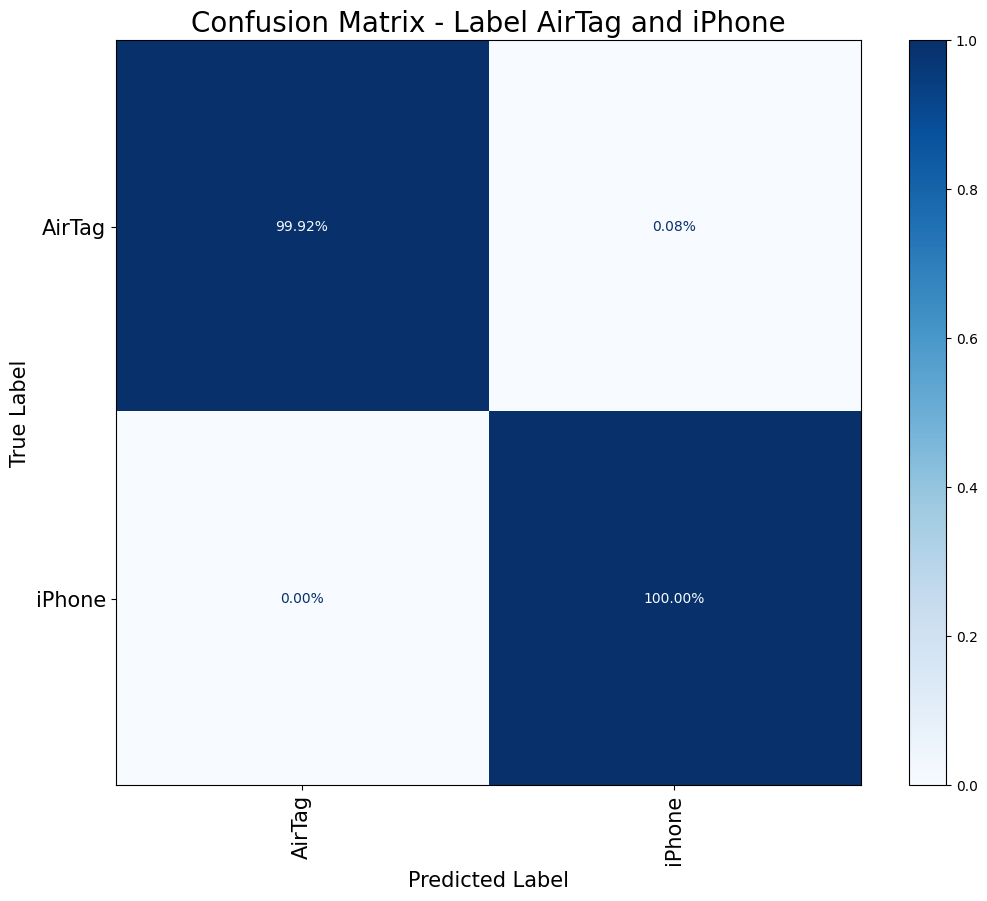

In [13]:
labeledFiles = [r"AirTag\AirTag_(nearby)_labeled_training.csv",
                 ]

unlabeledFiles = [r"AirTag\AirTag_(nearby)_3h.csv"
                   ]

evaluationFiles = [r"AirTag\AirTag_(nearby)_labeled_evaluation.csv"
                    ]

task_label_AirTag_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig, 
                                                         labeledFiles=labeledFiles,
                                                         unlabeledFiles= unlabeledFiles,
                                                         evaluationFiles= evaluationFiles,
                                                         firstDevice=label_AirTag,
                                                         secondDevice=label_iPhone,
                                                         flags = flag_label_AirTag_and_iPhone)

taskGroup_Labeling_auto.add(task_label_AirTag_nearby_auto)

End of iteration 1, added 133212 new labels.
End of iteration 2, added 32175 new labels.
End of iteration 3, added 12 new labels.
End of iteration 4, added 7 new labels.


Classification Report - Label Chipolo and iPhone
              precision    recall  f1-score   support

     Chipolo     1.0000    0.9965    0.9982      1144
      iPhone     0.9996    1.0000    0.9998     10420

    accuracy                         0.9997     11564
   macro avg     0.9998    0.9983    0.9990     11564
weighted avg     0.9997    0.9997    0.9997     11564


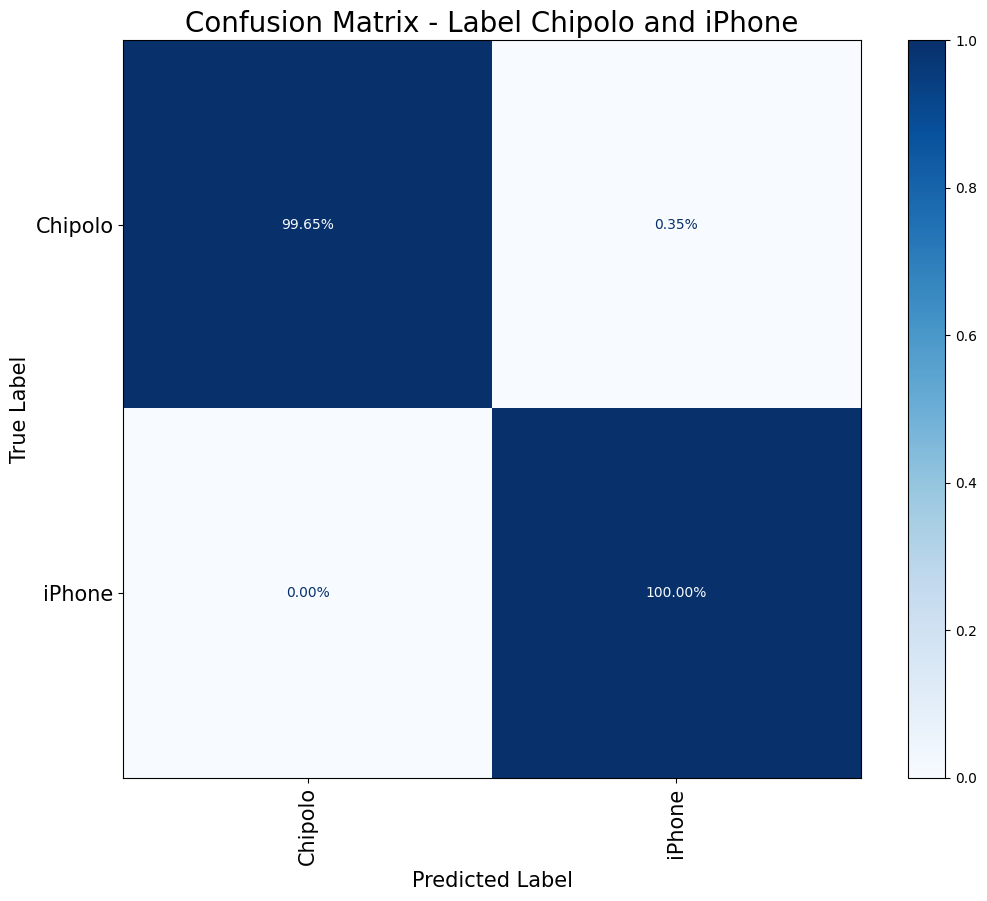

In [14]:
labeledFiles = [r"Chipolo\Chipolo_(nearby)_labeled_training.csv",
                ]

unlabeledFiles = [r"Chipolo\Chipolo_(nearby)_3h.csv"
                  ]

evaluationFiles = [r"Chipolo\Chipolo_(nearby)_labeled_evaluation.csv"
                   ]

task_label_Chipolo_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig,
                                                          labeledFiles=labeledFiles,
                                                          unlabeledFiles= unlabeledFiles,
                                                          evaluationFiles= evaluationFiles,
                                                          firstDevice=label_Chipolo,
                                                          secondDevice=label_iPhone,
                                                          flags = flag_label_Chipolo_and_iPhone)

taskGroup_Labeling_auto.add(task_label_Chipolo_nearby_auto)

End of iteration 1, added 131549 new labels.
End of iteration 2, added 21151 new labels.


Classification Report - Label SkyTag and iPhone
              precision    recall  f1-score   support

      SkyTag     1.0000    0.9990    0.9995       988
      iPhone     0.9999    1.0000    0.9999      9357

    accuracy                         0.9999     10345
   macro avg     0.9999    0.9995    0.9997     10345
weighted avg     0.9999    0.9999    0.9999     10345


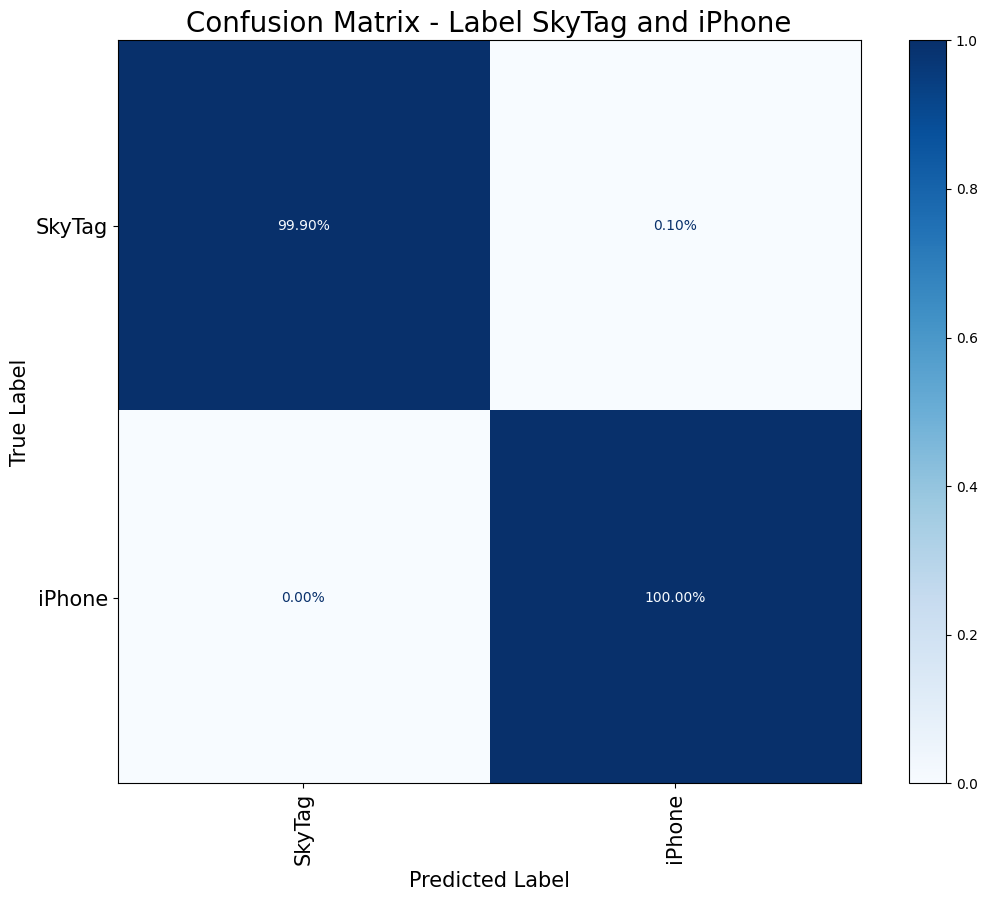

In [15]:
labeledFiles = [r"SkyTag\SkyTag_(nearby)_labeled_training.csv",
                ]

unlabeledFiles = [r"SkyTag\SkyTag_(nearby)_3h.csv"
                  ]

evaluationFiles = [r"SkyTag\SkyTag_(nearby)_labeled_evaluation.csv"
                   ]

task_label_SkyTag_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig,
                                                          labeledFiles=labeledFiles,
                                                          unlabeledFiles= unlabeledFiles,
                                                          evaluationFiles= evaluationFiles,
                                                          firstDevice=label_SkyTag,
                                                          secondDevice=label_iPhone,
                                                          flags = flag_label_SkyTag_and_iPhone)

taskGroup_Labeling_auto.add(task_label_SkyTag_nearby_auto)

End of iteration 1, added 133269 new labels.
End of iteration 2, added 24355 new labels.
End of iteration 3, added 1 new labels.

Classification Report - Label Tile and iPhone
              precision    recall  f1-score   support

        Tile     1.0000    0.9981    0.9990      1033
      iPhone     0.9999    1.0000    0.9999     18619

    accuracy                         0.9999     19652
   macro avg     0.9999    0.9990    0.9995     19652
weighted avg     0.9999    0.9999    0.9999     19652


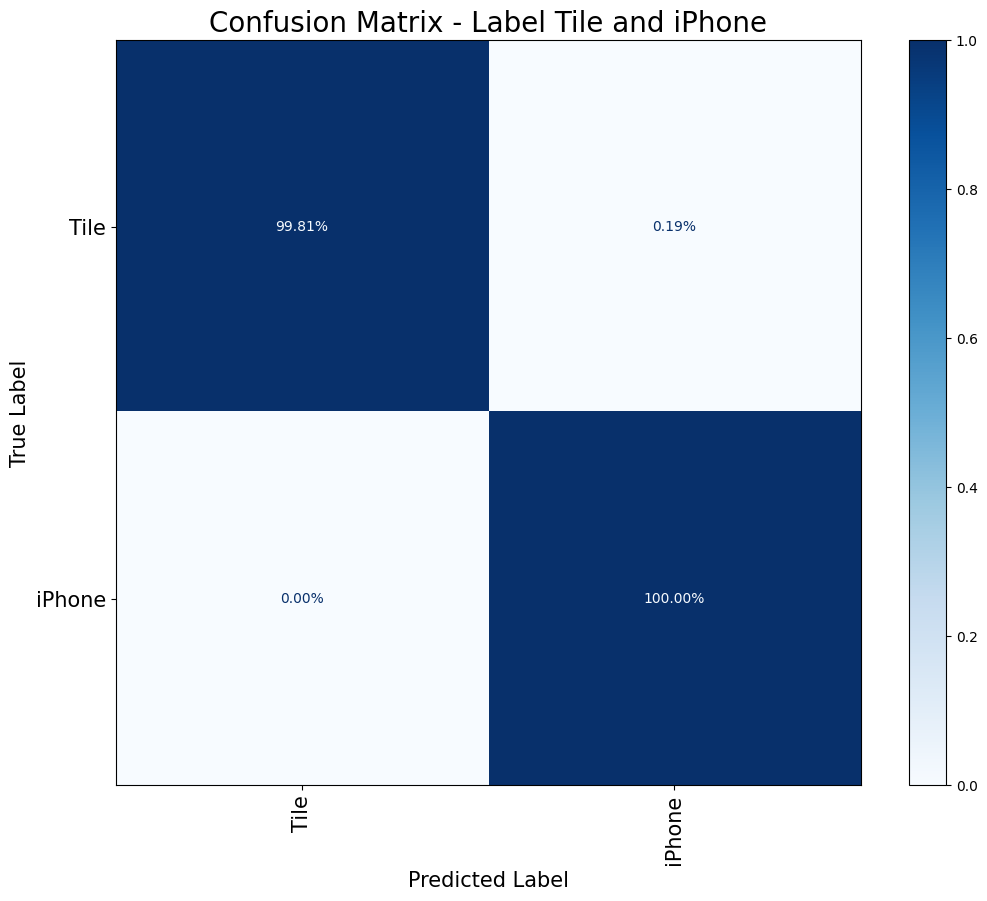

In [16]:
labeledFiles = [r"Tile\Tile_(nearby)_labeled_training.csv",
                ]

unlabeledFiles = [r"Tile\Tile_(nearby)_3h.csv"
                  ]

evaluationFiles = [r"Tile\Tile_(nearby)_labeled_evaluation.csv"
                   ]

task_label_Tile_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig,
                                                         labeledFiles=labeledFiles,
                                                         unlabeledFiles= unlabeledFiles,
                                                         evaluationFiles= evaluationFiles,
                                                         firstDevice=label_Tile,
                                                         secondDevice=label_iPhone,
                                                         flags = flag_label_Tile_and_iPhone)

taskGroup_Labeling_auto.add(task_label_Tile_nearby_auto)

End of iteration 1, added 101682 new labels.
End of iteration 2, added 152166 new labels.
End of iteration 3, added 4 new labels.


Classification Report - Label AirPod and iPhone
              precision    recall  f1-score   support

      AirPod     1.0000    1.0000    1.0000      5143
      iPhone     1.0000    1.0000    1.0000      3661

    accuracy                         1.0000      8804
   macro avg     1.0000    1.0000    1.0000      8804
weighted avg     1.0000    1.0000    1.0000      8804


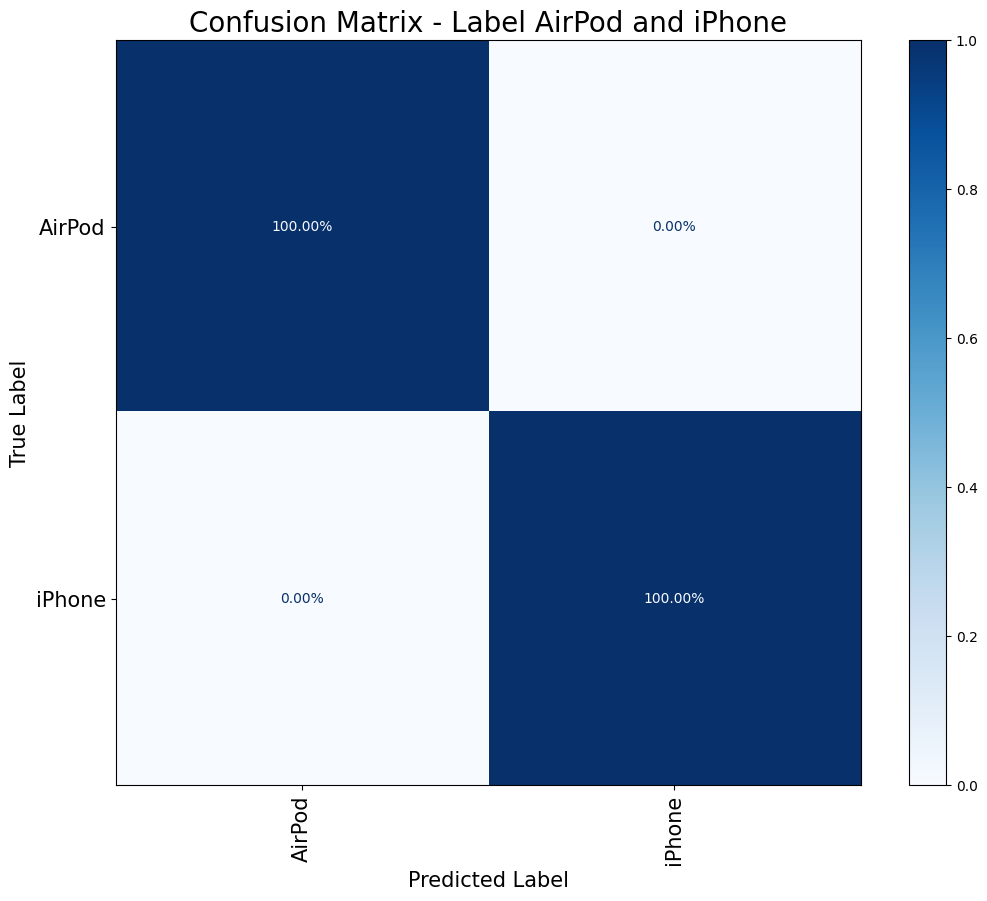

In [17]:
labeledFiles = [r"AirPod\AirPod_(nearby)_labeled_training.csv",
                ]

unlabeledFiles = [r"AirPod\AirPod_(nearby)_3h.csv"
                  ]

evaluationFiles = [r"AirPod\AirPod_(nearby)_labeled_evaluation.csv"
                   ]

task_label_AirPod_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig,
                                                         labeledFiles=labeledFiles,
                                                         unlabeledFiles= unlabeledFiles,
                                                         evaluationFiles= evaluationFiles,
                                                         firstDevice=label_AirPod,
                                                         secondDevice=label_iPhone,
                                                         flags = flag_label_AirPod_and_iPhone, 
                                                         selection=slice(0, 50), 
                                                         threshold=0.8)

taskGroup_Labeling_auto.add(task_label_AirPod_nearby_auto)



Classification Report - Label other Device and SmartTag
              precision    recall  f1-score   support

    SmartTag     1.0000    0.9934    0.9967       303
other Device     0.9996    1.0000    0.9998      5413

    accuracy                         0.9997      5716
   macro avg     0.9998    0.9967    0.9983      5716
weighted avg     0.9997    0.9997    0.9996      5716



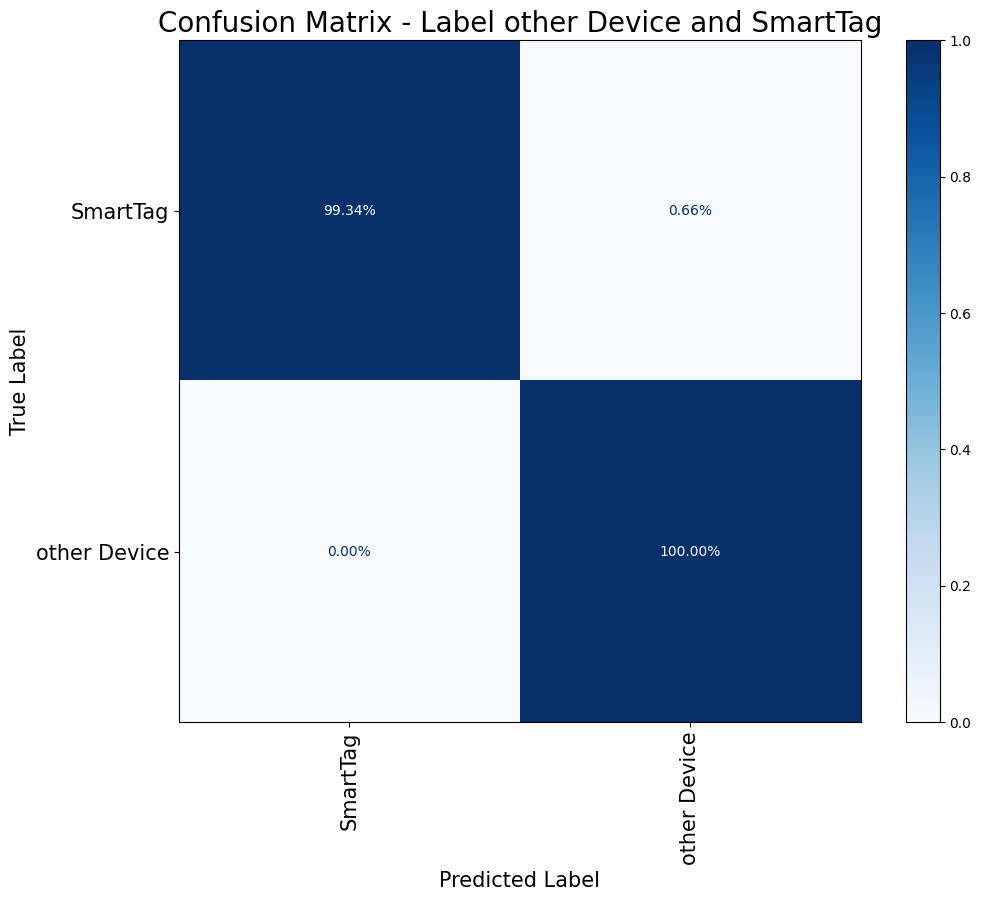

In [18]:
labeledFiles = [r"SmartTag\SmartTag_(nearby)_labeled_training_V1.csv",
                r"SmartTag\SmartTag_(nearby)_labeled_training_V2.csv",
                r"SmartTag\SmartTag_(nearby)_labeled_training_V3.csv"
                ]

unlabeledFiles = [#r"SmartTag\SmartTag_(nearby)_3h.csv"
                  ]

evaluationFiles = [r"SmartTag\SmartTag_(nearby)_labeled_evaluation_V1.csv",
                   r"SmartTag\SmartTag_(nearby)_labeled_evaluation_V2.csv",
                   r"SmartTag\SmartTag_(nearby)_labeled_evaluation_V3.csv"
                   ]

task_label_SmartTag_nearby_auto = nearbyTrackerTaskFactory(BaseConfig=NearbyTrackerConfig,
                                                           labeledFiles=labeledFiles,
                                                           unlabeledFiles=unlabeledFiles,
                                                           evaluationFiles=evaluationFiles,
                                                           firstDevice=label_other_Device,
                                                           secondDevice=label_SmartTag,
                                                           flags=flag_label_SmartTag_and_Other
                                                         )

taskGroup_Labeling_auto.add(task_label_SmartTag_nearby_auto)

In [19]:
for label in device_labels:
    task =  Task("Label " + label, executor = ex.labeling(label = label), flags = label_flag_lut[label])
    taskGroup_Labeling_manual.add(task)

taskGroup_Labeling.add(taskGroup_Labeling_manual)
taskGroup_Labeling.add(taskGroup_Labeling_auto)

AnalysisPipeline.add(taskGroup_Labeling)
AnalysisPipeline.print(priority=True)

Analysis Pipeline
	10 Pre Processing
		10 Select and order columns
		15 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		20 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		25 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		30 Fill Numeric NA with 0
		40 Fill String NA with None
		50 Broadcast
		60 Datetime conversion
		70 Malformed Packet
		80 Order DataFrame
		90 Convert object type to string
	20 Dummy Processing
		20 Dummies Protocol
		30 Dummies Channel
		40 Dummies AD Type
		50 Dummies Company
		55 Dummies UUID
		70 Dummies PDU Type
		80 Dummies Continuity Type
		90 Dummies SmartTag Type
	30 Labeling
		10 Labeling auto
			Label AirTag and iPhone
			Label Chipolo and iPhone
			Label SkyTag and iPhone
			Label Tile and iPh

In [20]:
stateColumn = 'State'

taskGroup_states = TaskGroup("States", priority=40, idempotency=True, flags = flag_states)

task_stateColumn = Task("State Column", executor = ex.instantiateStateColumn(stateColumn = stateColumn), priority=10) 
task_collapseStateColumn = Task("Collapse State Column", executor = ex.collapseStateColumn(stateColumn = stateColumn))

taskGroup_states_iDevices =  TaskGroup("States iDevices", priority=20, idempotency=True, flags = flag_states_iDevices)

task_findMy = Task("Continuity", executor = ex.addStateContinuityType(labelColumn="Label",
                                                                     typeColumn="Continuity Type",
                                                                     types = continuityTypes,
                                                                     MS_DataColumn_Length= 'Length MS Data',
                                                                     strike = 100,
                                                                     seperator=' ',
                                                                     stateColumn='State',
                                                                     labels=labels_iDevices)
                      )
                      
task_offline = Task("offline", executor= ex.addState(stateColumn=stateColumn, stateLabel="(offline)", labels = labels_iDevices), flags = flag_state_offline)
task_online = Task("online", executor= ex.addState(stateColumn=stateColumn, stateLabel="(online)", labels = labels_iDevices), flags = flag_state_online)


taskGroup_states_iDevices.addAll([task_findMy, task_online, task_offline])

taskGroup_states_Trackers =  TaskGroup("States Trackers", priority=30, idempotency=True, flags = flag_states_Tracker)

task_lost =  Task("lost", executor= ex.addState(stateColumn=stateColumn, stateLabel="(lost)", labels = labels_trackers + [label_AirPod]), flags = flag_state_lost)
task_nearby =  Task("nearby", executor= ex.addState(stateColumn=stateColumn, stateLabel="(nearby)",  labels = labels_trackers + [label_AirPod]), flags = flag_state_nearby)
task_unpaired = Task("unpaired", executor= ex.addState(stateColumn=stateColumn, stateLabel="(unpaired)", labels = labels_trackers), flags = flag_state_unpaired)
task_searching = Task("searching", executor= ex.addState(stateColumn=stateColumn, stateLabel="(searching)", labels = labels_trackers), flags = flag_state_searching)

taskGroup_states_Trackers.addAll([task_lost, task_nearby, task_unpaired, task_searching])

taskGroup_states.addAll([task_stateColumn, task_collapseStateColumn, taskGroup_states_iDevices, taskGroup_states_Trackers])

taskGroup_states.print(priority=True, flags = True)

40 States: States
	10 State Column
	20 States iDevices: States iDevices
		Continuity
		online: State online
		offline: State offline
	30 States Trackers: States Tracker
		lost: State lost
		nearby: State nearby
		unpaired: State unpaired
		searching: State searching
	Collapse State Column


In [21]:
AnalysisPipeline.add(taskGroup_states)
AnalysisPipeline.print(priority=True, flags = True)

Analysis Pipeline
	10 Pre Processing: Pre Processing
		10 Select and order columns
		15 Company ID and UUID
			10 Fill Company ID with None
			20 Fill UUID with None
			30 Replace Company IDs
			40 Replace Company UUIDs
		20 MS Data Processing
			10 Fill MS Data with empty String
			20 Length of MS Data
			30 Continuity Type
			40 Drop MS Data Column
		25 Service Data Processing
			10 Fill Service Data with empty String
			20 Length of Service Data
			30 Samsung Type
			40 Drop Service Data Column
		30 Fill Numeric NA with 0
		40 Fill String NA with None
		50 Broadcast
		60 Datetime conversion
		70 Malformed Packet
		80 Order DataFrame
		90 Convert object type to string
	20 Dummy Processing: Dummy Processing
		20 Dummies Protocol
		30 Dummies Channel
		40 Dummies AD Type
		50 Dummies Company
		55 Dummies UUID
		70 Dummies PDU Type
		80 Dummies Continuity Type
		90 Dummies SmartTag Type
	30 Labeling: Labeling
		10 Labeling auto: Labeling auto
			Label AirTag and iPhone: Label AirTag and

In [22]:
import pickle

with open(picklePath + AnalysisPipeline.getName() + '.pickle', 'wb') as f:
    pickle.dump(AnalysisPipeline, f)

In [23]:
flags = list(set(flags))

for flag in flags:
    with open(picklePath  + flag.getName() + '.pickle', 'wb') as f:
        pickle.dump(flag, f)
